# Preliminary Info

**Model - SimpleAvgEmbed :** Simply takes the average of all tokens' embeddings inside a cell and passes to the FF Linear Layer for a Naive binary classification.

**Data Hierarchy Train/Val/Test = (80-10-10) : big > medium > small > tiny > micro > teeny**
- **big** (800 - 100 - 100)
- **medium** (400 - 50 - 50)
- **small** (200 - 25 - 25)
- **tiny** (100 - 12 - 12)
- **micro** (50 - 6 - 6)
- **teeny** (25 - 3 - 3)


# Colab Setup

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Navigate to the directory
%cd /content/drive/My Drive/Coding/idea/modules/runcolab

/content/drive/My Drive/Coding/idea/modules/runcolab


# Setup

## Imports

In [ ]:
# Import importlib to reload modules and sys and os to add the path for other imports
import importlib
import sys
import os

# Append the parent directory to the path to import the necessary modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import the utilities and the dataloader
from utils import selfutil, trainutil, inferutil
from classes import SpreadsheetDataLoader, SimpleAvgEmbed

# Now reload the modules to ensure they are up-to-date
importlib.reload(selfutil)
importlib.reload(trainutil)
importlib.reload(inferutil)
importlib.reload(SpreadsheetDataLoader)
importlib.reload(SimpleAvgEmbed)

# Import the funcs needed from utils
from utils.selfutil import get_vocab, get_fileList, create_embeddings
from utils.trainutil import train_model
from utils.inferutil import infer_one, infer_full

# Import the SpreadsheetDataLoader class
from classes.SpreadsheetDataLoader import SpreadsheetDataLoader
from classes.SimpleAvgEmbed import SimpleAvgEmbed

# Other regular imports
import torch.nn as nn
import torch
from tqdm import tqdm
import gc
import os
import pandas as pd
import math
import time
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter


# Setup device as a global constant
devstr = "cuda:0"  # Change to "cpu" or "mps" as needed
gpu = False if (devstr == 'cpu') else True

# Determine the device to use
if devstr.startswith('cuda') and torch.cuda.is_available():
    DEVICE = torch.device(devstr)
elif devstr.startswith('mps') and torch.backends.mps.is_available():
    DEVICE = torch.device(devstr)
else:
    DEVICE = 'cpu'  # Default to CPU if none of the above are available

# Determine the global count of threads to use in parallel operations
THREADS = 1

print(DEVICE)

cuda:0


## Seed Set

In [ ]:
def set_seed(seed: int):
    """
    Set seed for reproducibility across CPU, CUDA, and MPS devices.

    Args:
        seed (int): The seed value to set.
    """
    # Set Python's built-in random seed
    random.seed(seed)

    # Set NumPy's seed
    np.random.seed(seed)

    # Set PyTorch seed for CPU
    torch.manual_seed(seed)

    # Check if CUDA is available and set seed for all CUDA devices
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)  # For all GPUs
        torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
        torch.backends.cudnn.benchmark = False  # Disable auto-tuning for reproducibility

    # Check if MPS (Metal Performance Shaders) is available and set seed
    if torch.backends.mps.is_available():
        torch.manual_seed(seed)  # Applies the seed to MPS operations as well

    # Optional: Ensure reproducibility by controlling environment variable
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Print confirmation
    print(f"Seed set to: {seed}")

set_seed(0)

Seed set to: 0


In [ ]:
# # Set the directory containing the spreadsheets for vocab training
# test_dir = '../data/train_manual/'

# # Initialize a counter to store file extensions and their counts
# file_extensions = Counter()

# # Initialize a variable to count the total files
# total_files = 0

# # Iterate through the files in the specified directory
# for file_name in os.listdir(test_dir):
#     # Check if the item is a file
#     if os.path.isfile(os.path.join(test_dir, file_name)):
#         # Get the file extension
#         _, extension = os.path.splitext(file_name)
#         # Increment the counter for the file extension
#         file_extensions[extension] += 1
#         # Increment the total file counter
#         total_files += 1

# # Print the total number of files
# print(f"Total files: {total_files}")

# # Print the count of files by extension
# for ext, count in file_extensions.items():
#     print(f"{ext}: {count}")

## Vocab/Embeddings

In [ ]:
# Set the directory containing the spreadsheets for vocab training
vocab_dir = '../data/train_manual/'

# Get the vocabulary object and embeddings
spreadsheet_vocab = get_vocab(vocab_dir, 150000, space = False, case = 'both', threads = THREADS)
spreadsheet_wvs = create_embeddings(spreadsheet_vocab)

Getting Vocab: 100%|██████████| 40/40 [00:05<00:00,  7.38it/s]


40(P) = 40(G) + 0(E)
Unique Tokens: 5592
Vocab Size: 5596


Creating Word Embeddings: 100%|██████████| 5596/5596 [00:00<00:00, 54824.94it/s]

Word Embeddings Shape: torch.Size([5596, 50])


## File List and DataLoaders

In [ ]:
# Define the directories
train_dir = '../data/train_manual/'
val_dir = '../data/val_manual/'
test_dir = '../data/test_manual/'

# Get the files for each directory
train_files = get_fileList(train_dir)
val_files = get_fileList(val_dir)
test_files = get_fileList(test_dir)

# Print the number of files in each list
print(f"Train files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Test files: {len(test_files)}\n")

# Decide max_rows, max_cols and num_tokens defaults 100, 100, 32
max_rows = 50
max_cols = 50
num_tokens = 64

# Create the data loaders
train_loader = SpreadsheetDataLoader(train_files, spreadsheet_vocab, max_rows, max_cols, num_tokens, threads = THREADS)
val_loader = SpreadsheetDataLoader(val_files, spreadsheet_vocab, max_rows, max_cols, num_tokens, threads = THREADS)
test_loader = SpreadsheetDataLoader(test_files, spreadsheet_vocab, max_rows, max_cols, num_tokens, threads = THREADS)

Train files: 40
Validation files: 5
Test files: 5



Processing files: 100%|██████████| 40/40 [00:02<00:00, 16.55it/s]



40(P) = 40(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 3174.14it/s]



5(P) = 5(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 3343.14it/s]



5(P) = 5(G) + 0(E)


In [ ]:
# failed_count = len(train_loader.failed_files)
# print(f"\nFailed files in train_loader: {failed_count}")

# # Print the failed files for the train_loader
# if train_loader.failed_files:
#     print("Failed files in train_loader:")
#     for file in train_loader.failed_files:
#         print(file)
# else:
#     print("No failed files in train_loader.")


# Model Training

## Define the model

In [ ]:
# Define the untrained model and move it to the device
untrained_model = SimpleAvgEmbed(spreadsheet_wvs).to(DEVICE)
print(untrained_model)

SimpleAvgEmbed(
  (_embed): Embedding(5596, 50)
  (_drop): Dropout(p=0.05, inplace=False)
  (_pred): Linear(in_features=50, out_features=1, bias=True)
)


In [ ]:
# # Get a single batch to test with
# check_loader = torch.utils.data.DataLoader(train_loader, batch_size=5, shuffle=False)
#
# # Get one batch from the DataLoader
# batch = next(iter(check_loader))
#
# # Move the extracted x_tok to gpu
# exfile = batch['x_tok'].to(DEVICE)
#
# # Define model
# untrained_model = SimpleAvgEmbed(spreadsheet_wvs).to(DEVICE)
#
# # Observe the model
# out = untrained_model.forward(exfile)
#
# print(f'Model Structure:\n{untrained_model}')
# print(out.shape)

# Training Loop

In [ ]:
# Define the model training parameters
trained_model = train_model(
    model = untrained_model,
    train_data = train_loader,
    val_data = val_loader,
    DEVICE = DEVICE,
    batch_size = 40,
    lr = 1e-3,
    mu = 0.25,
    max_epochs = 22,
    patience = 3,
    save_int = 0,
    save_dir = '../models/',
    save_name = 'simpleavgembed_big'
)

# Evaluation

## Single File for Train/Val/Test


Filename: ../data/train_manual/portfoliobyloantype.xls

--- Sigmoid Probabilities for Bold Cells ---
Cell (0, 0): 0.71013277769088745117
Cell (0, 1): 0.71013277769088745117
Cell (0, 2): 0.71013277769088745117
Cell (0, 3): 0.71013277769088745117
Cell (0, 4): 0.71013277769088745117
Cell (0, 5): 0.71013277769088745117
Cell (0, 6): 0.71013277769088745117
Cell (0, 7): 0.71013277769088745117
Cell (0, 8): 0.71013277769088745117
Cell (0, 9): 0.71013277769088745117
Cell (0, 10): 0.71013277769088745117
Cell (0, 11): 0.71013277769088745117
Cell (0, 12): 0.71013277769088745117
Cell (0, 13): 0.71013277769088745117
Cell (0, 14): 0.71013277769088745117
Cell (0, 15): 0.71013277769088745117
Cell (5, 2): 0.71828204393386840820
Cell (5, 3): 0.71828204393386840820
Cell (5, 4): 0.72061389684677124023
Cell (5, 5): 0.72061389684677124023
Cell (5, 6): 0.70964205265045166016
Cell (5, 7): 0.70964205265045166016
Cell (5, 8): 0.71784603595733642578
Cell (5, 9): 0.71784603595733642578
Cell (5, 10): 0.718581855297

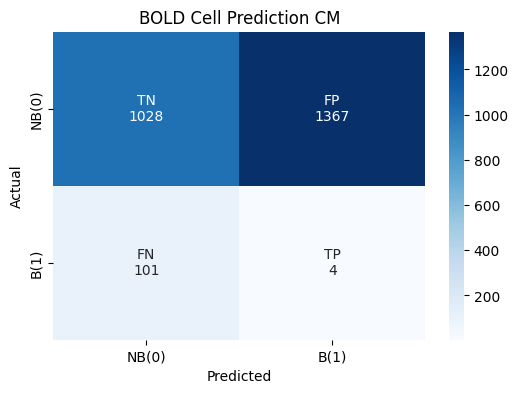


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from utils import inferutil
importlib.reload(inferutil)
from utils.inferutil import infer_one

infer_one(trained_model, train_loader, loc=0, disp_max = True, threshold = 0.5, condition = '>', device = DEVICE)


Filename: ../data/val_manual/portfolio-by-debt-size.xls

--- Sigmoid Probabilities for Bold Cells ---
Cell (0, 0): 0.69306087493896484375
Cell (0, 1): 0.69306087493896484375
Cell (0, 2): 0.69306087493896484375
Cell (0, 3): 0.69306087493896484375
Cell (0, 4): 0.69306087493896484375
Cell (0, 5): 0.69306087493896484375
Cell (0, 6): 0.69306087493896484375
Cell (0, 7): 0.69306087493896484375
Cell (0, 8): 0.69306087493896484375
Cell (0, 9): 0.69306087493896484375
Cell (0, 10): 0.69306087493896484375
Cell (0, 11): 0.69306087493896484375
Cell (0, 12): 0.69306087493896484375
Cell (0, 13): 0.69306087493896484375
Cell (0, 14): 0.69306087493896484375
Cell (0, 15): 0.69306087493896484375
Cell (0, 16): 0.69306087493896484375
Cell (0, 17): 0.69306087493896484375
Cell (0, 18): 0.69306087493896484375
Cell (0, 19): 0.69306087493896484375
Cell (4, 2): 0.70418262481689453125
Cell (4, 3): 0.70418262481689453125
Cell (4, 4): 0.70864909887313842773
Cell (4, 5): 0.70864909887313842773
Cell (4, 6): 0.70736676

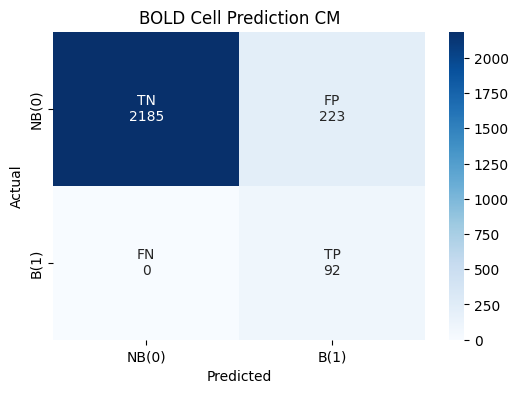


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,1
7,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,1
8,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,1
9,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,1



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
infer_one(trained_model, val_loader, loc=1, disp_max = True, threshold = 0.69, condition = '>', device = DEVICE)


Filename: ../data/test_small/lindy_donoho_000_1_1_1.pst.111.xls

--- Sigmoid Probabilities for Bold Cells ---
Cell (17, 0): 0.57846379280090332031
Cell (25, 0): 0.57770425081253051758
Cell (34, 0): 0.57730644941329956055
Cell (43, 0): 0.57142663002014160156
Cell (48, 0): 0.58396929502487182617
Cell (59, 0): 0.58251655101776123047
Cell (76, 0): 0.58420771360397338867

NB to B ratio: Predicted = 4473:5527 | Actual = 9993:7
Accuracy: 44.74% | Precision: 0.07% | Recall: 57.14% | F1-Score: 0.00



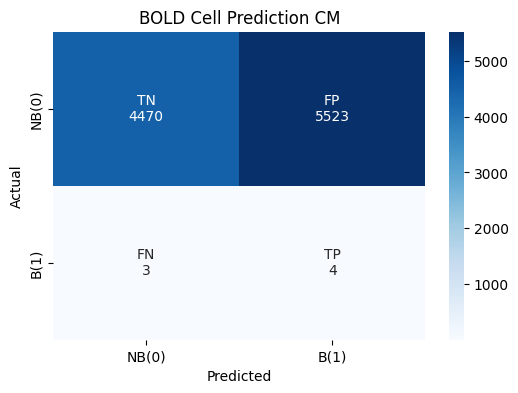


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0
17,1
25,1
34,1
43,1
48,1
59,1
76,1


In [ ]:
infer_one(trained_model, test_loader, loc=1, disp_max = True, threshold = 0.58, condition = '<', device = DEVICE)